# Timeseries prediction using LSTM

## Introduction
This notebook shows how lstm model predict price in timeseries data.

## Setup

In [1]:
!pip install matplotlib
!pip install seaborn
!pip install bs4

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

tf.random.set_seed(2021)

## Load the dataset
[FinanceDataReader](https://github.com/FinanceData/FinanceDataReader) is an open source library for collecting and analyzing financial data such as price data (stocks, indices, exchange rates, futures, etc.) Therefore, you don't need to download file and get latest updated data by calling API.

The dataset contains 6 columns and timestamped. If you define like `df = fdr.DataReader('AMXN', '2017')`, it reads Amazon's stock data from 2017-01-01 to now. You can set specific date and for more details, go to FinanceDataReader github.

- Open: Opening price
- High: High price
- Low: Low price
- Close: Closing price
- Volume: Trading volume
- Change: Price change

In [3]:
!pip install finance-datareader

In [4]:
import FinanceDataReader as fdr

stock = fdr.DataReader('AMZN', '2017')

In [5]:
stock.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14',
               '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20',
               '2021-05-21', '2021-05-24'],
              dtype='datetime64[ns]', name='Date', length=1105, freq=None)

In [6]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

stock.head()

,Close,Open,High,Low,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2017-01-03,753.67,757.92,758.76,747.70,3520000.0,0.0051,2017,1,3
2017-01-04,757.18,758.39,759.68,754.20,2510000.0,0.0047,2017,1,4
2017-01-05,780.45,761.55,782.40,760.26,5830000.0,0.0307,2017,1,5
2017-01-06,795.99,782.36,799.44,778.48,5990000.0,0.0199,2017,1,6
2017-01-09,796.92,798.00,801.77,791.77,3450000.0,0.0012,2017,1,9


## Visualize the data

Text(0, 0.5, 'price')

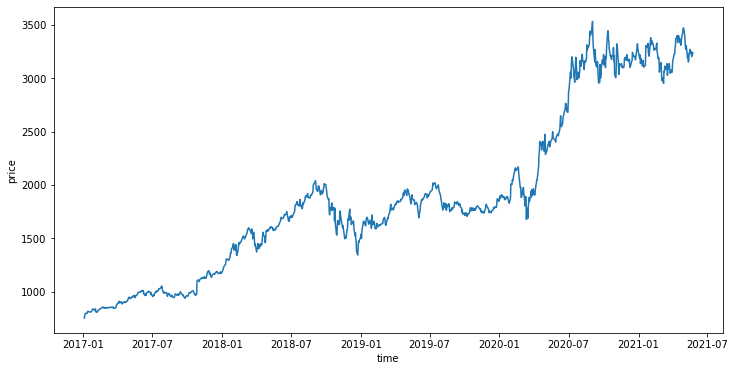

In [7]:
plt.figure(figsize = (12, 6))
sns.lineplot(y = stock['Close'], x = stock.index)
plt.xlabel('time')
plt.ylabel('price')

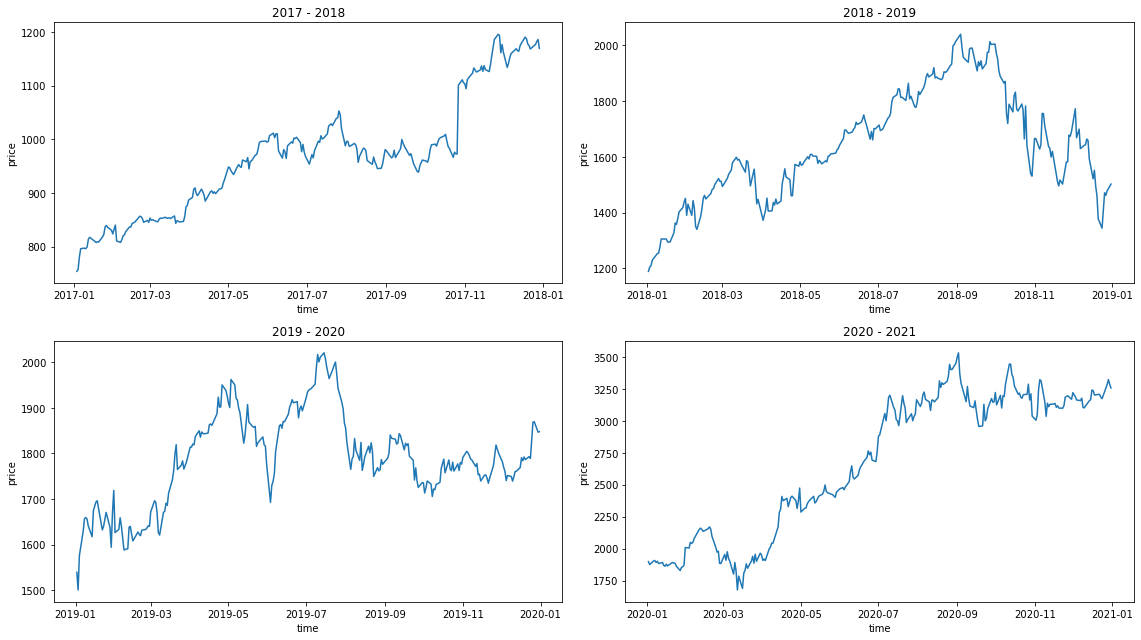

In [8]:
time_steps = [['2017', '2018'], 
              ['2018', '2019'], 
              ['2019', '2020'], 
              ['2020', '2021']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)

for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y = df['Close'], x = df.index, ax = ax)
    ax.set_title(f'{time_steps[i][0]} - {time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    
plt.tight_layout()
plt.show()

## Preapare training data
### Normalize data

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled_data = scaler.fit_transform(stock[scale_cols])
df = pd.DataFrame(scaled_data, columns = scale_cols)
df.head()

,Open,High,Low,Close,Volume
0,0.000000,0.000000,0.000000,0.000000,0.182096
1,0.000169,0.000329,0.002373,0.001264,0.118795
2,0.001302,0.008457,0.004586,0.009641,0.326875
3,0.008763,0.014553,0.011238,0.015235,0.336902
4,0.014370,0.015387,0.016090,0.015570,0.177709


### Split train and test data

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size = 0.3, random_state = 0, shuffle=False)
x_train.shape, x_test.shape

((773, 4), (332, 4))

In [11]:
input_size = x_train.shape[1]

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(x_train.shape[0], 1, input_size)
x_test = x_test.reshape(x_test.shape[0], 1, input_size)

x_train.shape, x_test.shape

((773, 1, 4), (332, 1, 4))

## Build a model

You build a LSTM model. The model take input of shape `(batch_size, window_size, n_features)` and return output of the same shape. In this case, `window_size` is 1 and `n_features` is 4.

`window_size` is a parameter that determines closing price of next day based on past period. For example, if `window_size = 10`, it predict future price with past 10 days.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM

model = Sequential()
model.add(LSTM(512,input_shape = (1,input_size)))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'relu'))

model.compile(loss ='mse', optimizer = 'rmsprop', metrics = ['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1058816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,059,329
Trainable params: 1,059,329
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [13]:
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 20, batch_size = 128,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')],
)

Train on 695 samples, validate on 78 samples
Epoch 1/20
695/695 [==============================] - 4s 6ms/sample - loss: 0.0396 - mae: 0.1620 - mape: 160274.5469 - val_loss: 0.0177 - val_mae: 0.1326 - val_mape: 35.1643
Epoch 2/20
695/695 [==============================] - 0s 298us/sample - loss: 0.0075 - mae: 0.0776 - mape: 177328.2500 - val_loss: 0.0054 - val_mae: 0.0728 - val_mape: 19.2670
Epoch 3/20
695/695 [==============================] - 0s 266us/sample - loss: 0.0051 - mae: 0.0630 - mape: 182019.5156 - val_loss: 0.0033 - val_mae: 0.0566 - val_mape: 14.9847
Epoch 4/20
695/695 [==============================] - 0s 318us/sample - loss: 0.0036 - mae: 0.0529 - mape: 172271.8281 - val_loss: 0.0018 - val_mae: 0.0420 - val_mape: 11.1016
Epoch 5/20
695/695 [==============================] - 0s 259us/sample - loss: 0.0024 - mae: 0.0425 - mape: 134727.0156 - val_loss: 0.0016 - val_mae: 0.0398 - val_mape: 10.5290
Epoch 6/20
695/695 [==============================] - 0s 291us/sample - loss:

## Evaluation
### Plot training and validation loss

In [14]:
pred = model.predict(x_test)

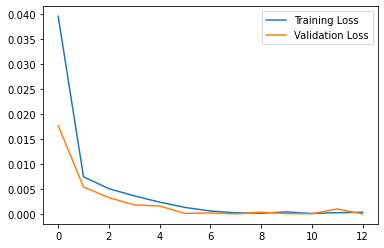

In [15]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

### Compare actual and prediction with test data

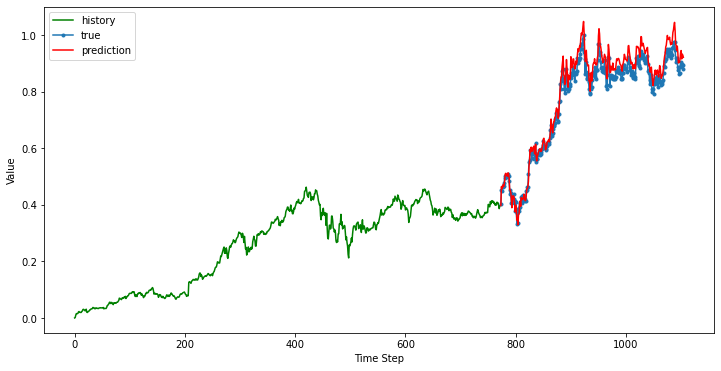

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label = 'history')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker = '.', label = 'true')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), pred, 'r', label = 'prediction')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

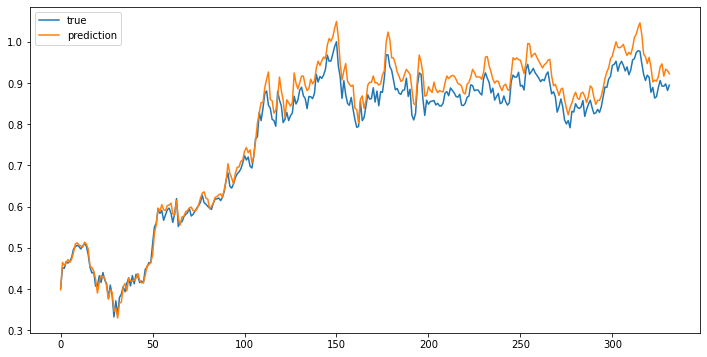

In [17]:
plt.figure(figsize = (12, 6))
plt.plot(np.asarray(y_test), label = 'true')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()